### Reqirements
- keras >= 2.2.0 or tensorflow >= 1.13
- segmenation-models==1.0.*
- albumentations==0.3.0

In [2]:
# Install required libs

### please update Albumentations to version>=0.3.0 for `Lambda` transform support
!pip install -U albumentations>=0.3.0 --user 
!pip install -U --pre segmentation-models --user

In [3]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

import math
import numpy as np
import tensorflow as tf
import keras

from PIL import Image
import matplotlib.pyplot as plt
from skimage.io import imread
from skimage.transform import resize
from glob import glob
import cv2

from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *

In [4]:
home_dir_path = os.path.join(os.getenv('HOME'), 'workplace/Hackerton')
data_dir_path = os.path.join(home_dir_path, 'RSI_OP_NIA_AIHUB')
dir_path = data_dir_path + '/buildings/training/'
test_path = data_dir_path + '/buildings/validation/'

In [5]:
x_train_dir = data_dir_path + '/buildings/training/raw/'
y_train_dir = data_dir_path + '/buildings/training/label_new/'

x_valid_dir = data_dir_path + '/buildings/validation/raw/'
y_valid_dir = data_dir_path + '/buildings/validation/label_new/'

In [6]:
from albumentations import HorizontalFlip, VerticalFlip, Compose, OneOf, Resize
import albumentations as A

def rgb2gray(rgb):
    gray = cv2.cvtColor(rgb, cv2.COLOR_BGR2GRAY)
    return gray


def build_augmentation(is_train=True):
    if is_train:    # 훈련용 데이터일 경우
        return Compose([
            HorizontalFlip(p=0.5),    # 50%의 확률로 좌우대칭
            VerticalFlip(p=0.5),
            OneOf(
                [
                    A.CLAHE(p=1),
                    A.RandomBrightness(p=1),
                    A.RandomGamma(p=1),
                ],
                p=0.9,
            ),
            OneOf(
            [
                A.RandomContrast(p=1),
                A.HueSaturationValue(p=1),
            ],
            p=0.9,
            ),
            Resize(              # 입력이미지를 256X256로 resize
                width=256,
                height=256
            )
        ])
    
    return Compose([      # 테스트용 데이터일 경우에는 256X256로 resize만 수행합니다.
        Resize(
            width=256,
            height=256
        )
    ])

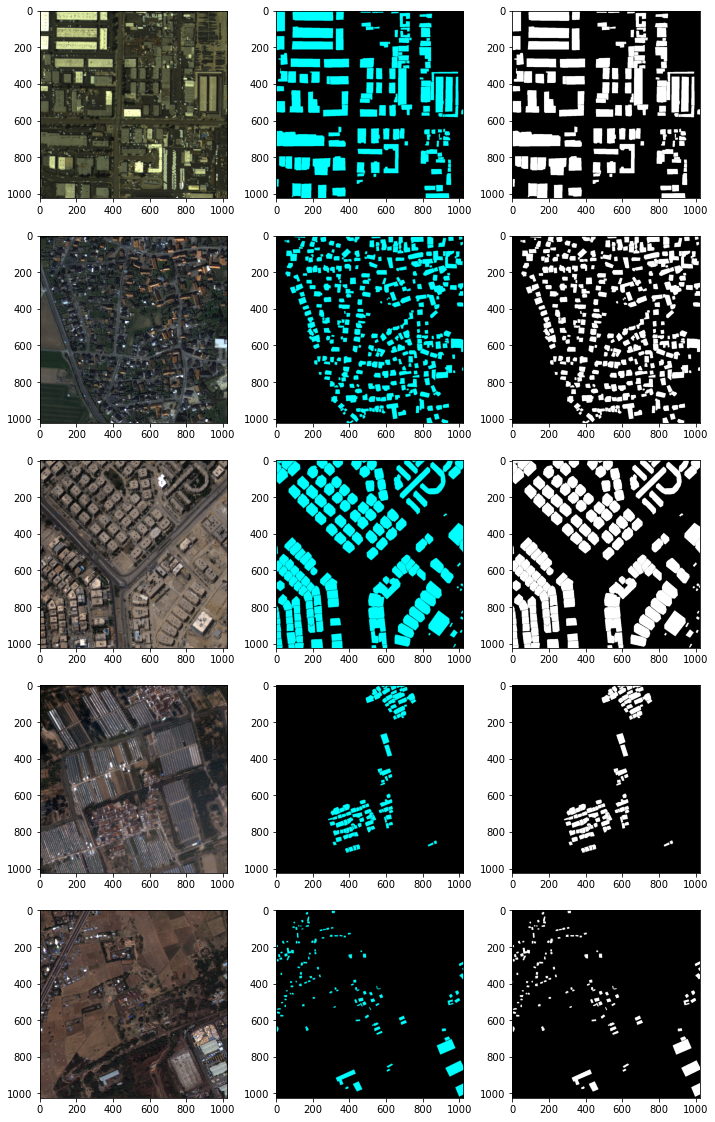

In [7]:
input_images = glob(os.path.join(x_train_dir, "*.png"))
label_images = glob(os.path.join(y_train_dir, "*.png"))

# 훈련 데이터셋에서 5개만 가져와 augmentation을 적용해 봅시다.  
plt.figure(figsize=(12, 20))
for i in range(5):
    image = imread(input_images[i]) 
    label = imread(label_images[i]) 
    gray = rgb2gray(label)
    plt.subplot(5, 3, 3*i+1)
    plt.imshow(image)  # 왼쪽이 원본이미지
    plt.subplot(5, 3, 3*i+2)
    plt.imshow(label)
    plt.subplot(5, 3, 3*i+3)
    plt.imshow(gray,cmap='Greys_r')  # gray
plt.show()

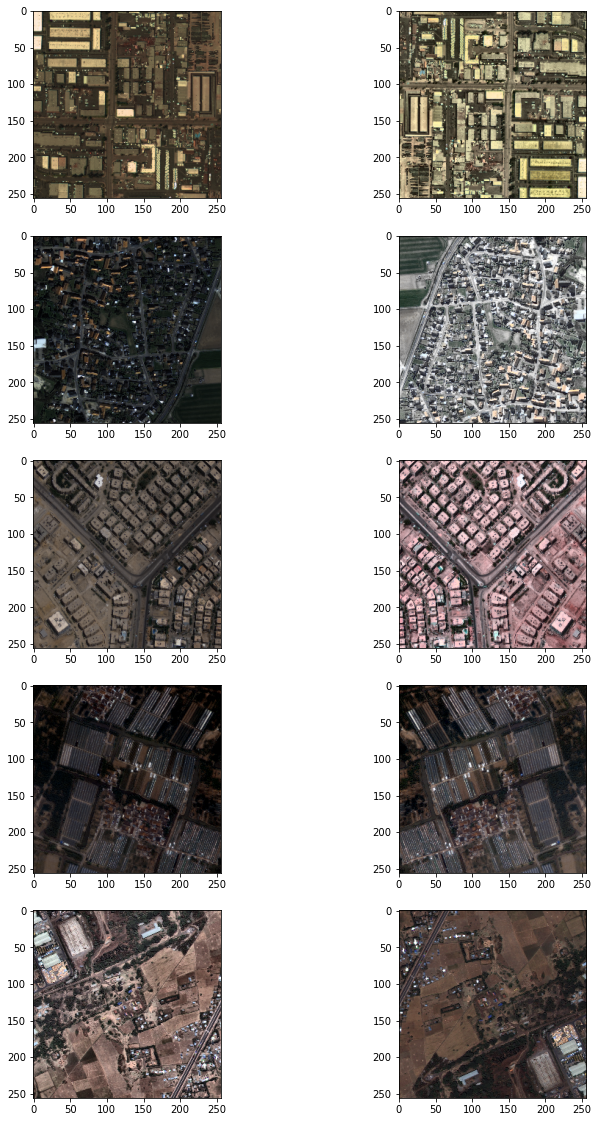

In [8]:
augmentation = build_augmentation()

# 훈련 데이터셋에서 5개만 가져와 augmentation을 적용해 봅시다.  
plt.figure(figsize=(12, 20))
for i in range(5):
    image = imread(input_images[i]) 
    image_data = {"image":image}
    resized = augmentation(**image_data, is_train=False)
    processed = augmentation(**image_data)
    plt.subplot(5, 2, 2*i+1)
    plt.imshow(resized["image"])  # 왼쪽이 원본이미지
    plt.subplot(5, 2, 2*i+2)
    plt.imshow(processed["image"])  # 오른쪽이 augment된 이미지
  
plt.show()

In [19]:
class SatelliteGenerator(tf.keras.utils.Sequence):
    '''
    SatelliteGenerator는 tf.keras.utils.Sequence를 상속받습니다.
    '''
    def __init__(self, 
                 dir_path,
                 batch_size=8,
                 img_size=(256, 256, 3),
                 output_size=(256, 256),
                 is_train=True,
                 augmentation=None):
        '''
        dir_path: dataset의 directory path입니다.
        batch_size: batch_size입니다.
        img_size: preprocess에 사용할 입력이미지의 크기입니다.
        output_size: ground_truth를 만들어주기 위한 크기입니다.
        is_train: 이 Generator가 학습용인지 테스트용인지 구분합니다.
        augmentation: 적용하길 원하는 augmentation 함수를 인자로 받습니다.
        '''
        self.dir_path = dir_path
        self.batch_size = batch_size
        self.is_train = is_train
        self.dir_path = dir_path
        self.augmentation = augmentation
        self.img_size = img_size
        self.output_size = output_size

        # load_dataset()을 통해서 Satellite dataset의 directory path에서 라벨과 이미지를 확인합니다.
        self.data = self.load_dataset()

    def load_dataset(self):
        # Satellite dataset에서 필요한 정보(이미지 경로 및 라벨)를 directory에서 확인하고 로드하는 함수입니다.
        # 이때 is_train에 따라 test set을 분리해서 load하도록 해야합니다.
        input_images = glob(os.path.join(self.dir_path, "raw", "*.png"))
        label_images = glob(os.path.join(self.dir_path, "label_new", "*.png"))
        input_images.sort()
        label_images.sort()
        assert len(input_images) == len(label_images)
        data = [ _ for _ in zip(input_images, label_images)]

        if self.is_train:
            return data[:-200] # train : valid : test = 1038 : 200 : 159
         
        return data[-200:] 
    
    def __len__(self):
        # Generator의 length로서 전체 dataset을 batch_size로 나누고 소숫점 첫째자리에서 올림한 값을 반환합니다.
        return math.ceil(len(self.data) / self.batch_size)

    def __getitem__(self, index):
        # 입력과 출력을 만듭니다.
        # 입력은 resize및 augmentation이 적용된 input image이고 
        # 출력은 semantic label입니다.
        batch_data = self.data[
                               index*self.batch_size:
                               (index + 1)*self.batch_size
                               ]
        inputs = np.zeros([self.batch_size, *self.img_size])
        outputs = np.zeros([self.batch_size, *self.output_size])
        
        for i, data in enumerate(batch_data):
            input_img_path, output_path = data
            _input = imread(input_img_path)
            _output = imread(output_path)
            # _output = (_output==7).astype(np.uint8)*1
            _output = rgb2gray(_output)
            data = {
                "image": _input,
                "mask": _output,
                }
            augmented = self.augmentation(**data)
            inputs[i] = augmented["image"]/255
            outputs[i] = augmented["mask"]/255
        
        return inputs, outputs

    def on_epoch_end(self):
        # 한 epoch가 끝나면 실행되는 함수입니다. 학습중인 경우에 순서를 random shuffle하도록 적용한 것을 볼 수 있습니다.
        self.indexes = np.arange(len(self.data))
        if self.is_train == True :
            np.random.shuffle(self.indexes)
        
        return self.indexes


In [20]:
augmentation = build_augmentation()
valid_preproc = build_augmentation(is_train=False)
test_preproc = build_augmentation(is_train=False)

train_generator = SatelliteGenerator(
    dir_path, 
    augmentation=augmentation,
)

valid_generator = SatelliteGenerator(
    dir_path, 
    augmentation=valid_preproc,
    is_train=False
)

test_generator = SatelliteGenerator(
    test_path, 
    augmentation=valid_preproc,
    is_train=False
)

# Baseline Model

In [21]:
%env SM_FRAMEWORK=tf.keras

env: SM_FRAMEWORK=tf.keras


In [22]:
import segmentation_models as sm

In [23]:
BACKBONE = 'efficientnetb3'
# BATCH_SIZE = 8
# CLASSES = ['car']
LR = 0.0001
EPOCHS = 40

preprocess_input = sm.get_preprocessing(BACKBONE)

In [24]:
# define network parameters
n_classes = 1 # if len(CLASSES) == 1 else (len(CLASSES) + 1)  # case for binary and multiclass segmentation
activation = 'sigmoid' # if n_classes == 1 else 'softmax'

#create model
model = sm.Unet(BACKBONE, classes=n_classes, activation=activation)

In [25]:
# define optomizer
optim = keras.optimizers.Adam(LR)

# Segmentation models losses can be combined together by '+' and scaled by integer or float factor
dice_loss = sm.losses.DiceLoss()
focal_loss = sm.losses.BinaryFocalLoss() if n_classes == 1 else sm.losses.CategoricalFocalLoss()
total_loss = dice_loss + (1 * focal_loss)

# actulally total_loss can be imported directly from library, above example just show you how to manipulate with losses
# total_loss = sm.losses.binary_focal_dice_loss # or sm.losses.categorical_focal_dice_loss 

metrics = [sm.metrics.IOUScore(threshold=0.5), sm.metrics.FScore(threshold=0.5)]

# compile keras model with defined optimozer, loss and metrics
model.compile(optim, total_loss, metrics)

In [26]:
# define callbacks for learning rate scheduling and best checkpoints saving
callbacks = [
    keras.callbacks.ModelCheckpoint('./best_model.h5', save_weights_only=True, save_best_only=True, mode='min'),
    keras.callbacks.ReduceLROnPlateau(),
]

In [27]:
# train model
history = model.fit_generator(
     generator=train_generator,
     validation_data=valid_generator,
     steps_per_epoch=len(train_generator),
     epochs=EPOCHS,
     callbacks=callbacks 
 )

model_path = dir_path + '/seg_model_unet.h5'
model.save(model_path)  #학습한 모델을 저장해 주세요.

Epoch 1/40
130/130 [==============================] - 143s 480ms/step - loss: 1.0002 - iou_score: 0.1889 - f1-score: 0.3019 - val_loss: 0.8552 - val_iou_score: 0.2822 - val_f1-score: 0.4377
Epoch 2/40
130/130 [==============================] - 60s 462ms/step - loss: 0.7756 - iou_score: 0.3228 - f1-score: 0.4745 - val_loss: 0.7876 - val_iou_score: 0.3380 - val_f1-score: 0.5033
Epoch 3/40
130/130 [==============================] - 60s 463ms/step - loss: 0.7117 - iou_score: 0.3548 - f1-score: 0.5075 - val_loss: 0.7677 - val_iou_score: 0.3291 - val_f1-score: 0.4934
Epoch 4/40
130/130 [==============================] - 60s 462ms/step - loss: 0.6580 - iou_score: 0.3940 - f1-score: 0.5511 - val_loss: 0.6557 - val_iou_score: 0.4028 - val_f1-score: 0.5725
Epoch 5/40
130/130 [==============================] - 60s 461ms/step - loss: 0.6407 - iou_score: 0.3986 - f1-score: 0.5550 - val_loss: 0.6357 - val_iou_score: 0.4032 - val_f1-score: 0.5730
Epoch 6/40
130/130 [==============================] - 

In [28]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
stem_conv (Conv2D)              (None, None, None, 4 1080        input_2[0][0]                    
__________________________________________________________________________________________________
stem_bn (BatchNormalization)    (None, None, None, 4 160         stem_conv[0][0]                  
__________________________________________________________________________________________________
stem_activation (Activation)    (None, None, None, 4 0           stem_bn[0][0]                    
____________________________________________________________________________________________

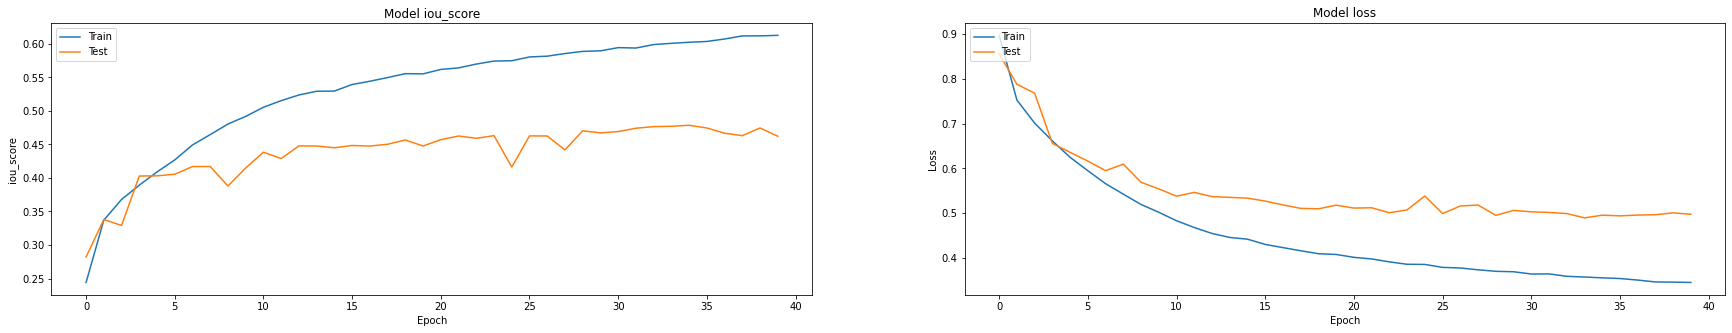

In [29]:
# Plot training & validation iou_score values
plt.figure(figsize=(30, 5))
plt.subplot(121)
plt.plot(history.history['iou_score'])
plt.plot(history.history['val_iou_score'])
plt.title('Model iou_score')
plt.ylabel('iou_score')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

# Plot training & validation loss values
plt.subplot(122)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [30]:
# load best weights
model.load_weights('best_model.h5')

In [31]:
scores = model.evaluate_generator(test_generator)

print("Loss: {:.5}".format(scores[0]))
for metric, value in zip(metrics, scores[1:]):
    print("mean {}: {:.5}".format(metric.__name__, value))

/home/aiffel-dj22/anaconda3/envs/aiffel/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:1877: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  warnings.warn('`Model.evaluate_generator` is deprecated and '


Loss: 0.4408
mean iou_score: 0.54273
mean f1-score: 0.7009


In [32]:
def get_output(model, preproc, image_path, output_path):
    origin_img = imread(image_path)
    data = {"image":origin_img}
    processed = preproc(**data)
    output = model(np.expand_dims(processed["image"]/255,axis=0))
    output = (output[0].numpy()>=0.5).astype(np.uint8).squeeze(-1)*255  #0.5라는 threshold를 변경하면 도로인식 결과범위가 달라집니다.
    
    output = Image.fromarray(output)
#    background = Image.fromarray(origin_img).convert('RGBA')
    output = output.resize((origin_img.shape[1], origin_img.shape[0])) # .convert('RGBA')
#    output = Image.blend(background, output, alpha=0.5)
    output.save(output_path)
    
    return output

In [39]:
test_input_images = glob(os.path.join(x_valid_dir, "*.png"))
test_label_images = glob(os.path.join(y_valid_dir, "*.png"))

In [42]:
for img in test_input_images:
    get_output(
        model, 
        test_preproc,
        image_path=img,
        output_path=dir_path + f'/output3/' + img.split("/")[-1]
    )

In [43]:
output_path=dir_path + "/output3/"
outputs = glob(os.path.join(output_path, "*.png"))

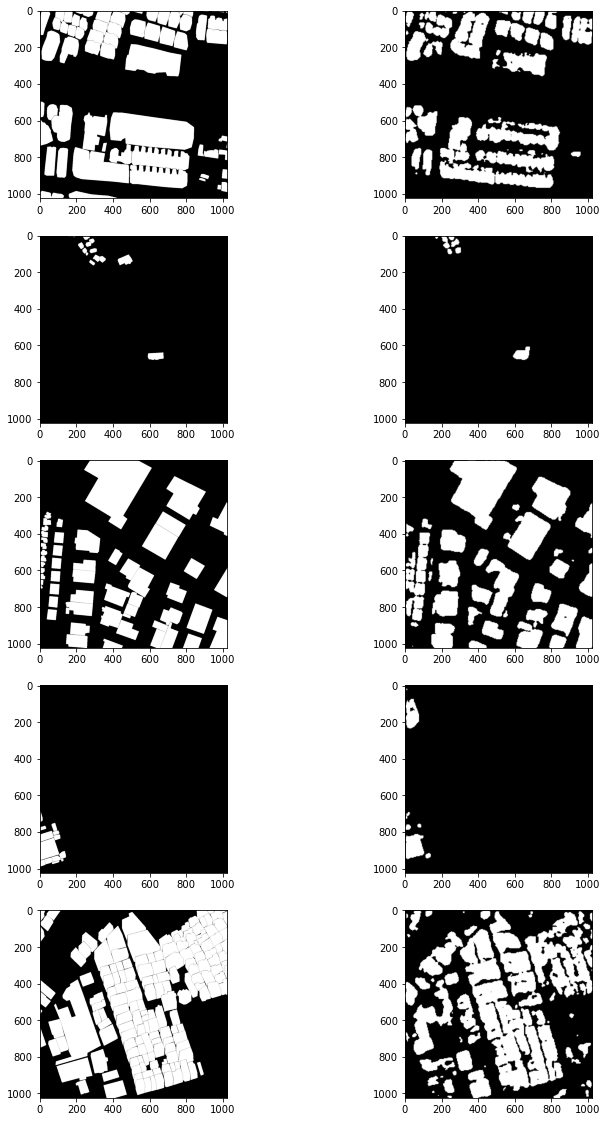

In [44]:
plt.figure(figsize=(12, 20))
for i in range(5):
#   image = imread(input_images[i]) 
    label = imread(test_label_images[i])
    gray = rgb2gray(label)
    prediction = imread(outputs[i])
    
    model
#   plt.subplot(5, 2, 2*i+1)
#   plt.imshow(image)  # 왼쪽이 원본이미지
    plt.subplot(5, 2, 2*i+1)
    plt.imshow(gray,cmap='Greys_r')
    plt.subplot(5, 2, 2*i+2)
    plt.imshow(prediction, cmap='Greys_r')
plt.show()

https://github.com/qubvel/segmentation_models/blob/master/examples/binary%20segmentation%20(camvid).ipynb